# Swimming Mammal Recognition

I will try and buil a ML algorithm that is capable of identifying almost 28k unique individual marine mammals belonging to 30 species.

Dataset can be downloaded from [here](https://www.kaggle.com/bdsaglam/happy-whale-512?select=sample_submission.csv). This is the "simplified version" of the [original dataset](https://www.kaggle.com/c/happy-whale-and-dolphin/data) in that all the figures have the same size (512x512) -- if smaller they have been padded. 

The files are already divided into train and test folders, although there is no `species` label associated to each test image. *** Review this ***

My idea is:
1. train a non-pretrained resnet34 network from scratches (`xresnet34` in the fastai libraries);
1. train a pretrained resnet34 network;
1. compare the results and comment on that.

## Downloading the dataset from kaggle

In [23]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [24]:
! kaggle datasets download bdsaglam/happy-whale-512

happy-whale-512.zip: Skipping, found more recently modified local copy (use --force to force download)


In [25]:
! unzip happy-whale-512.zip

Archive:  happy-whale-512.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Initial imports and setups

Upgrade fastai on colab (this noteboook worked with fastai version 2.5.3)

In [26]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [27]:
import fastai
fastai.__version__
# '2.5.3'

'2.5.3'

In [28]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [29]:
from fastai.vision.all import *
from fastai.callback import *
from fastai.metrics import error_rate
import pandas as pd
import os, csv

Import Drive in `/content/drive`

In [30]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Setting some variables:

In [31]:
item_size = 480
tfm_size = 224
bs = 64 #same as default, so I am not using it -- atm

## Creating dataloader

Defining all the paths and reading the csv file containing the labels (i.e. the mammal species) associated to each image.

In [39]:
path = '/content'
path_images = '/content/train_images'
#os.listdir(path_images)

path_labels = '/content/train.csv'
#* Read csv file using pandas
df = pd.read_csv(path_labels)
#df.head	#* printing datafile names

Creating the dictionary with the structure:

```
	image_name: species
```

and the function to retrieve the species starting from the filename.

In [33]:
species = {}
with open(path_labels) as file:
	reader = csv.DictReader(file)
	for row in reader:
		species[row['image']] = row['species']

def label_func(fname):
    return species[str(fname).split('/')[-1]]

Given our ***dataset*** we want to create a dataloader for it, that splits the dataset into a *test* and a *training* set. Images are resized to `item_size`x`item_size`, and are padded if necessary (should not, since the images I refer to in the link above are all larger, 512x512).

I load the images from the folder specified in `path/train_images` using the labels loaded from the csv file, saved in `df`:

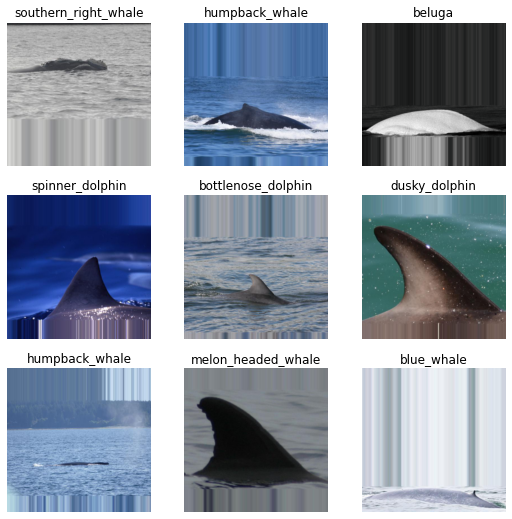

In [40]:
dls = ImageDataLoaders.from_df(df, 
	path,
	folder = 'train_images',
	item_tfms=Resize(item_size,method=ResizeMethod.Pad),
	batch_tfms=Normalize.from_stats(*imagenet_stats))

#dls.show_batch()

In [41]:
# getting all images in subfolders
fnames = get_image_files(path_images)
fnames[:10]

(#10) [Path('/content/train_images/cc02362b0307d3.jpg'),Path('/content/train_images/b86054cd930efc.jpg'),Path('/content/train_images/a688a91bef1158.jpg'),Path('/content/train_images/01d05c312c7c3e.jpg'),Path('/content/train_images/147fd1b92af9fd.jpg'),Path('/content/train_images/34d7ad0d20a03d.jpg'),Path('/content/train_images/abe81c02944673.jpg'),Path('/content/train_images/75593c7b27c5e2.jpg'),Path('/content/train_images/27d0c714ac7001.jpg'),Path('/content/train_images/47d0ed86ec4844.jpg')]

I now create the DataBlock, i.e. how to assemble data as follows:

1. grab the images with the built-in feature `get_image_files`;
1. grab the species associated to each image using the function I have defined above `label_func`;
1. transform the images, resizing them to 64x64 and padding them;
1. splitting the images into a validation and training set, setting myself a `seed` for the random number generator;
1. normalising the images within the batch

In [42]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
	get_items = get_image_files,
	get_y = label_func,
	item_tfms=Resize(item_size,method=ResizeMethod.Pad),
	splitter=RandomSplitter(valid_pct=.1, seed=42),
	batch_tfms=[*aug_transforms(size=tfm_size, max_warp=0), Normalize.from_stats(*imagenet_stats)]
	)


In [43]:
dsets = dblock.datasets(path_images)
no_species = len(dsets.vocab) # returns the total number of species

#dsets.train[:5]

[(PILImage mode=RGB size=512x512, TensorCategory(1)),
 (PILImage mode=RGB size=512x512, TensorCategory(3)),
 (PILImage mode=RGB size=512x512, TensorCategory(0)),
 (PILImage mode=RGB size=512x512, TensorCategory(0)),
 (PILImage mode=RGB size=512x512, TensorCategory(4)),
 (PILImage mode=RGB size=512x512, TensorCategory(0)),
 (PILImage mode=RGB size=512x512, TensorCategory(0)),
 (PILImage mode=RGB size=512x512, TensorCategory(14)),
 (PILImage mode=RGB size=512x512, TensorCategory(17)),
 (PILImage mode=RGB size=512x512, TensorCategory(18))]

We don't need to do anything else since the images are already of size 512x512 and if smaller, these are patched.

We can now transform the DataBlock into DataLoaders, using a batchsize of 16

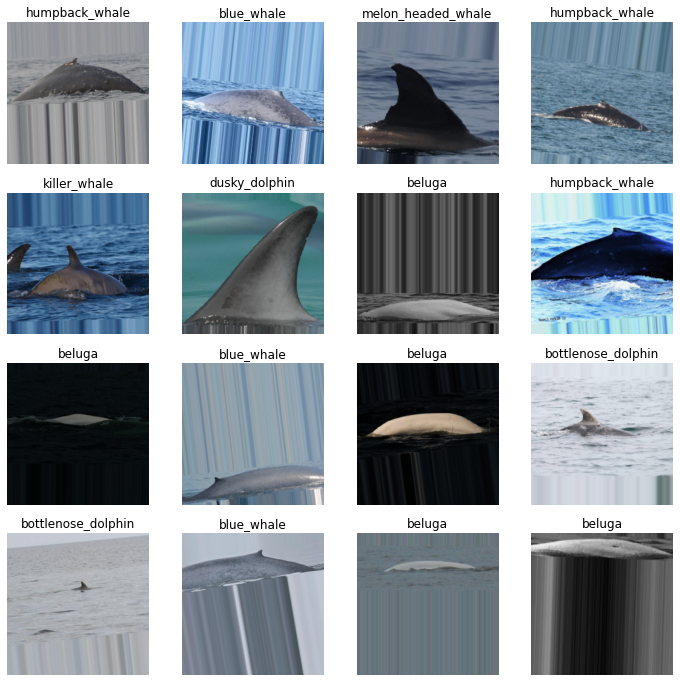

In [44]:
dls = dblock.dataloaders(path_images)
dls.show_batch(max_n=16)

## Start the learning process

We want to train a model from scratch since there is no such a pre-trained NN.

We might use a CNN learner with the `pretrained` option set to `False`, or otherwise we can a set of resnet models that have "all the tricks from modern research incorporated". Basically I use xresnet34 and xresnet50 models, specifying the number of classes we expect to see as a result, and nothing else. I will do and comment all the steps for the xresnet34 and then repeat them all in the xresnet50 case.

### xresnet34

I define here two models to use for fitting, namely xresnet34 and xresnet50 with no particular activation functions or any further specification.

In [45]:
netw34_subopt = xresnet34(n_out=no_species, pretrained = False)
# netw34_subopt[0]

Launching the learning process. In order to do so, I specify the metrics, `accuracy` and `error_rate`.

In [46]:
learn34_subopt = Learner(dls,model = netw34_subopt, metrics =[accuracy,error_rate])

I then take a look at the suggested learning rate, to find:

SuggestedLRs(valley=0.0020892962347716093)

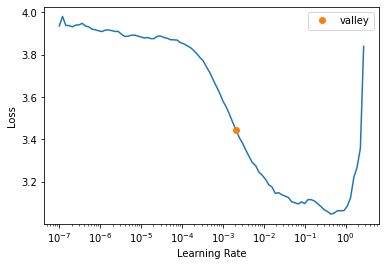

In [47]:
learn34_subopt.lr_find()
# SuggestedLRs(valley=0.0020892962347716093)

I now launch the `fit_one_cycle` procedure with the optimal lr obtained in the previous cell with `lr_find()`:

In [48]:
learn34_subopt.fit_one_cycle(5,2e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.129066,1.292973,0.602587,0.397413,13:03
1,0.716325,0.706647,0.777190,0.222810,12:41
2,0.464009,0.481727,0.848520,0.151480,12:56
3,0.292308,0.291693,0.901039,0.098961,12:41
4,0.219960,0.217124,0.931805,0.068195,12:58


Saving the model first:

In [49]:
learn34_subopt.save('dorsal_xresnet34_v2') # v1 I have produced using my laptop, and was not really satisfactory

Path('models/dorsal_xresnet34_v2.pth')

Checking the results:

In [50]:
learn34_subopt.summary()

XResNet (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 112 x 112 
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 112 x 112 
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                             

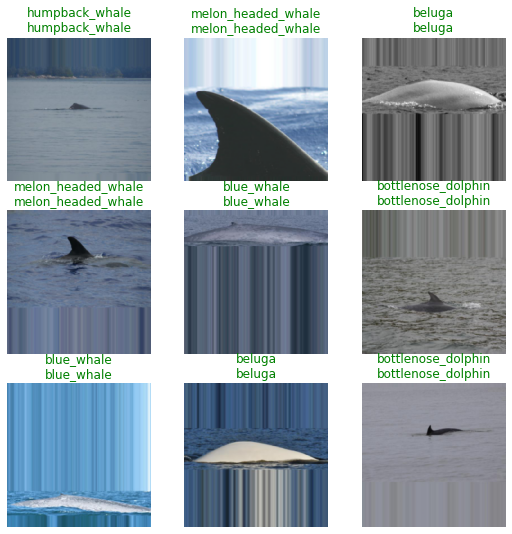

In [51]:
learn34_subopt.show_results()

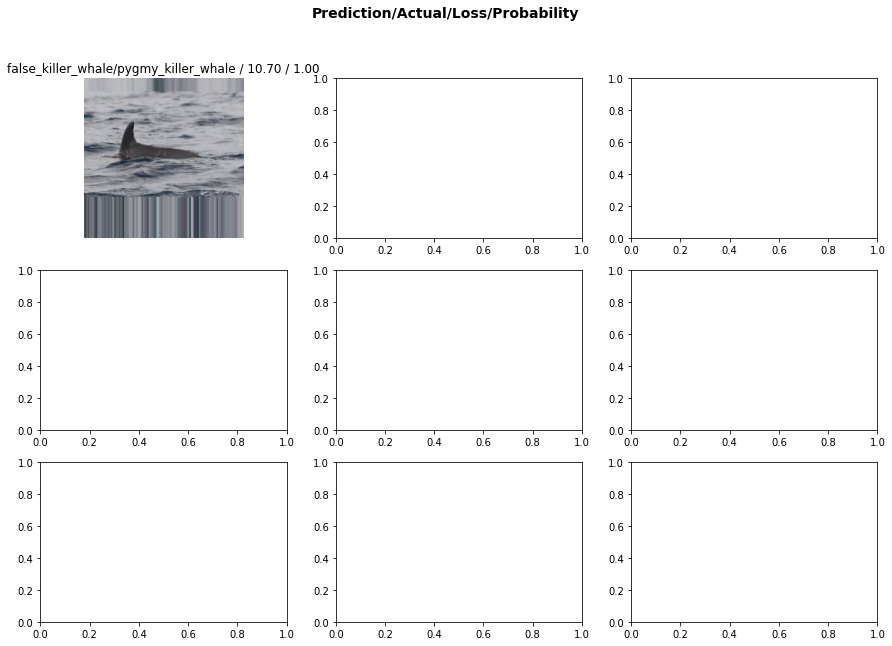

In [54]:
interp34 = ClassificationInterpretation.from_learner(learn34_subopt)
interp34.plot_top_losses(9,figsize=(15,10)) # Bug in Fastai here -- only plots one.

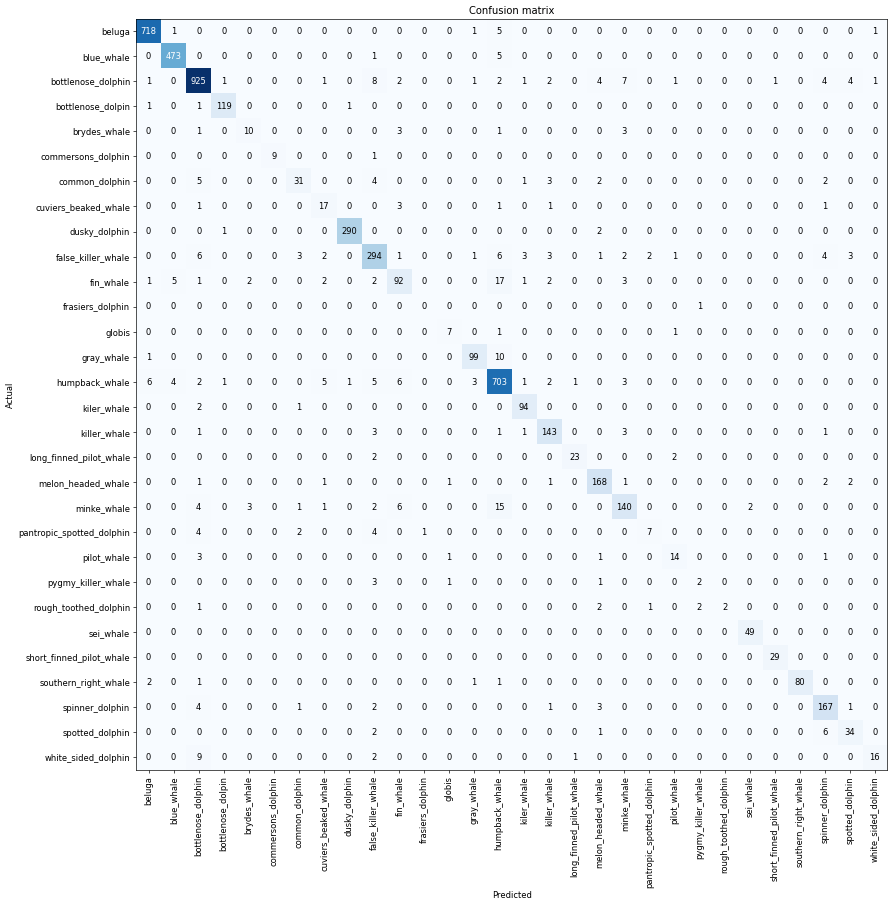

In [56]:
interp34.plot_confusion_matrix(figsize=(15,15), dpi=60)

In [57]:
interp34.most_confused(min_val=5)

[('fin_whale', 'humpback_whale', 17),
 ('minke_whale', 'humpback_whale', 15),
 ('gray_whale', 'humpback_whale', 10),
 ('white_sided_dolphin', 'bottlenose_dolphin', 9),
 ('bottlenose_dolphin', 'false_killer_whale', 8),
 ('bottlenose_dolphin', 'minke_whale', 7),
 ('false_killer_whale', 'bottlenose_dolphin', 6),
 ('false_killer_whale', 'humpback_whale', 6),
 ('humpback_whale', 'beluga', 6),
 ('humpback_whale', 'fin_whale', 6),
 ('minke_whale', 'fin_whale', 6),
 ('spotted_dolphin', 'spinner_dolphin', 6),
 ('beluga', 'humpback_whale', 5),
 ('blue_whale', 'humpback_whale', 5),
 ('common_dolphin', 'bottlenose_dolphin', 5),
 ('fin_whale', 'blue_whale', 5),
 ('humpback_whale', 'cuviers_beaked_whale', 5),
 ('humpback_whale', 'false_killer_whale', 5)]

## Second

As an alternative, I  used the pre-trained `resnet34` and `resnet50` learners, in order to see whether there is an improvement in the 

In [58]:
dblock_pretrained = DataBlock(blocks = (ImageBlock, CategoryBlock),
	get_items = get_image_files,
	get_y = label_func,
	item_tfms=Resize(item_size,method=ResizeMethod.Pad),
	splitter=RandomSplitter(valid_pct=.1, seed=42),
	batch_tfms=[*aug_transforms(size=tfm_size, max_warp=0), Normalize.from_stats(*imagenet_stats)]
	# batch_tfms=Normalize.from_stats(*imagenet_stats)
	)


In [59]:
dls_pretrained = dblock_pretrained.dataloaders(
	path_images
	)

In [71]:
learn_pretrained = cnn_learner(dls_pretrained, resnet34, metrics=[accuracy,error_rate])
learn_pretrained.lr_find()
# SuggestedLRs(valley=0.0030199517495930195) ## Sorry, I mistakenly cancelled the output

In [73]:
learn_pretrained.fit_one_cycle(3,3e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.872935,0.885135,0.757202,0.242798,11:52
1,0.509345,0.447494,0.863218,0.136782,11:17
2,0.329133,0.228008,0.929061,0.070939,11:21


Unfreezing and fine-tuning:

In [74]:
learn_pretrained.unfreeze()

In [75]:
learn_pretrained.fit_one_cycle(2, 3e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.294918,1.487432,0.590045,0.409955,12:18
1,0.797277,5.188845,0.782285,0.217715,11:44
2,0.487593,0.368240,0.884186,0.115814,11:39


That looks worse than the unfrozen case. My suspect is that some individuals have marks on their back/fin. Such characteristic signs are very well captured and recognised by the pretrained model, that as a consequence is very reliable. On the other hand, when the `unfreeze` is operated, this ability to recognise the characteristic signs is lost, hence the drop down in the accuracy. This phenomenon is worth investigating -- sadly, I have no time (at least not enough, at the moment) but I will work on it in a non-better specified future. 

Looking at the summary and the results:

In [76]:
learn_pretrained.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

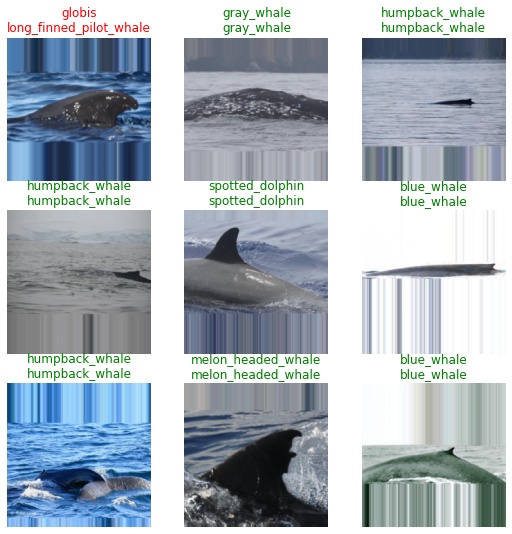

In [77]:
learn_pretrained.show_results()

Getting the top losses, confusion matrix and most confused elements:

In [ ]:
interp_pretrained = ClassificationInterpretation.from_learner(learn_pretrained)
interp_pretrained.plot_top_losses(9,figsize=(15,10))

In [ ]:
interp_pretrained.plot_confusion_matrix(figsize=(15,15), dpi=60)

In [ ]:
interp_pretrained.most_confused(min_val=20)

Saving the model:



In [ ]:
learn_pretrained.save('dorsal_pretrained_resnet34_v2')

## Results

The pretrained `resnet34` gives better/comparable results than/with the untrained `xresnet`. Unexpectedly, when the former is unfrozen and then retrained, the results are worse than in the latter case. I have given an explanation on why that happens: basically, the pretrained model might grasping some characteristic features of the individuals that are then not recognised later when unfreezing. I will investigate it at some point, but at the moment I have no time. Together with that, I will try using a `resnet50` or `xresnet50` although the results were already above 90%.

Also, the competition was demanding the ability to recognise single individuals, which is something that I need to spend more time (and Colab resources) on.


---

The last lines are not compiled because the Colab session closed unexpectedly.